## Run config
**Traffic specification**
* Traffic Low: 3h interval
* Traffic Medium: 2h interval
* Traffic High: 1h interval

### Initialize + Auxiliary functions

In [63]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pandas.plotting import table
%matplotlib inline

terrestrial_processor_flops = 6.80 * 1e9 # 6.80 GFlops, i7-7700K single core

# Proton 200k
spatial_processor_flops = 900 * 1e6 # 900 MFlops
processor_power_consumption = 1.5 # W
slowing_factor = terrestrial_processor_flops / spatial_processor_flops # 7.55

# EnduroSat X-band Transmitter
transmitter_power = 12 # W
transmitter_Mbps = 150

traffic_names = ['TrafficLow', 'TrafficMedium', 'TrafficHigh']
configs = ['Bfs', 'FirstEnded'] + traffic_names

In [96]:
def categorise_ax_legend(ax):
    h, l = ax.get_legend_handles_labels()
    l = list(map(translate_config, l))
    d1, = ax.plot([0], marker='None', linestyle='None')
    d2, = ax.plot([0], marker='None', linestyle='None')
    ax.legend([d1, *h[:2], d2, *h[2:]], [r'$\bf{Centralizado}$', *l[:2], r'$\bf{Distribuido}$', *l[2:]])
    return ax

def filter_df_by_modules(df, modules):
    module_list = ['dtnsim.node[{}].dtn'.format(i) for i in modules]
    boolean_index = df['module'].isin(module_list)
    
    return df[boolean_index]

def get_computed_routes(df, modules=None):
    computed_routes = df[
        (df["name"] == "routeCgrRouteTableEntriesCreated:sum") &
        (df["type"] == "scalar")
    ]
    if modules is not None:
        computed_routes = filter_df_by_modules(computed_routes, modules)
        
    computed_routes = computed_routes.groupby("run").sum().reset_index()
    computed_routes['value'] = computed_routes['value'].astype(int)
    computed_routes = computed_routes.rename(columns={'value': 'ComputedRoutes'})
    return computed_routes

def get_dest_only_computed_routes(df, modules=None):
    crtdn = df[(df['name'] == 'routeCgrCentralizedFilteredRoutes:sum') & (df['type'] == 'scalar')]
    if modules is not None:
        crtdn = filter_df_by_modules(crtdn, modules)
    
    crtdn = crtdn.groupby('run').sum()
    return crtdn.reset_index().rename(columns={'value': 'ComputedRoutes'})

def get_config(df):
    config_name = df[df['attrname'] == 'configname'][['run', 'attrvalue']]
    config_name = config_name.rename(columns={'attrvalue': 'Config'})
    return config_name

def get_iteration_vars(df, name=None):
    itvars = df[
        df["type"] == 'itervar'
    ]
    if name is None:
        return itvars[['run', 'attrname', 'attrvalue']]
    else:
        itvars = itvars[itvars['attrname'] == name]
        itvars = itvars.rename(columns={'attrvalue': name})
        return itvars[['run', name]]

def get_mean_delay(df):
    delay = df[
        (df["name"] == "appBundleReceivedDelay:mean") &
        (df["type"] == "scalar")
    ]
    delay = delay.groupby("run").mean().reset_index()
    delay = delay.rename(columns={'value': 'Mean Delay'})
    return delay[['run', 'Mean Delay']]

def get_packet_delay_hist(df, receiver_node):
    apd = df[
        (df['module'] == 'dtnsim.node[' + str(receiver_node) + '].app') &
        (df['name'] == 'appBundleReceivedDelay:histogram') &
        (df['type'] == 'histogram')
    ]
    config = get_config(df)
    apd = merge_dfs([config, apd])

    binedges = apd[['Config', 'binedges']]
    binedges = pd.concat([binedges, binedges['binedges'].str.split(expand=True).apply(pd.to_numeric)], axis=1)
    binedges = binedges.drop(columns=['binedges'])
    binedges = binedges.set_index('Config')

    binval = apd[['Config', 'binvalues']]
    binval = pd.concat([binval, binval['binvalues'].str.split(expand=True).apply(pd.to_numeric)], axis=1)
    binval = binval.drop(columns=['binvalues'])
    binval = binval.set_index('Config')
    binval = binval.T[configs]

    binval['binedges'] = binedges.iloc[0, :].astype(int)
    binval = binval.set_index('binedges')

    return binval

def get_packets_sent(df):
    sent = df[
        (df['type'] == 'scalar') &
        (df['name'] == 'appBundleSent:count')
    ]
    sent = sent.groupby('run').sum().reset_index()
    sent['value'] = sent['value'].astype(int)
    sent = sent[['run', 'value']].rename(columns={'value': 'PacketsSent'})
    return sent

def get_packets_received(df, module):
    recv = df[
        (df['module'] == 'dtnsim.node[' + str(module) + '].app') &
        (df['name'] == 'appBundleReceived:count') &
        (df['type'] == 'scalar')
    ]
    recv = recv[['run', 'value']].rename(columns={'value': 'PacketsReceived'})
    return recv
    
def get_route_length_mean(df, modules=None, group_by_run=True):
    route_length = df[
        (df["name"] == "routeCgrRouteLength:mean") &
        (df["type"] == "scalar")
    ]
    if modules is not None:
        route_length = filter_df_by_modules(route_length, modules)
        
    if group_by_run:
        route_length = route_length.groupby("run").mean().reset_index()
    route_length = route_length.rename(columns={'value': 'RouteLengthMean'})
    return route_length

def get_time_df(df, filter_modules=None, spatial_modules=None, slowing_factor=1.0, agg_func='sum'):
    time_to_compute_routes = df[
        (df["name"] == "routeCgrTimeToComputeRoutes:sum") &
        (df["type"] == "scalar")
    ]
    if filter_modules is not None:
        time_to_compute_routes = filter_df_by_modules(time_to_compute_routes, filter_modules)
    
    if spatial_modules is not None:
        config = get_config(df)
        time_to_compute_routes = merge_dfs([time_to_compute_routes, config], drop_run=False)
        distr_modules = time_to_compute_routes.loc[time_to_compute_routes['Config'].isin(traffic_names)]
        ind = filter_df_by_modules(distr_modules, spatial_modules).index
        time_to_compute_routes.loc[ind, 'value'] = time_to_compute_routes.loc[ind, 'value'] * slowing_factor
        time_to_compute_routes.drop(columns='Config', inplace=True)
    
    if agg_func == 'sum':
        time_to_compute_routes = time_to_compute_routes.groupby("run").sum().reset_index()
        
    time_to_compute_routes = time_to_compute_routes.rename(columns={'value': 'SpentTime'})
    return time_to_compute_routes

def get_route_size_estimation(df, modules=None, get_routes_func=get_computed_routes):
    route_length_mean = get_route_length_mean(df, modules=modules)
    computed_routes = get_routes_func(df, modules=modules)

    size_estimation = (1 + route_length_mean['RouteLengthMean']) * 4 # id + each hop with an identifier of an int
    size_estimation = size_estimation * computed_routes['ComputedRoutes']
    size_estimation /= 1024 ** 2 # MB
    size_estimation = size_estimation.round(2)
    size_estimation = pd.DataFrame({
        'run': route_length_mean['run'],
        'RouteSizeEstimation(MB)': size_estimation
    })
    return size_estimation

def get_power_consumption_distributed(df, spatial_modules, slowing_factor=1.0, processor_power_consumption=1.0):
    time_df = get_time_df(df,
        filter_modules=spatial_modules,
        spatial_modules=spatial_modules,
        slowing_factor=slowing_factor)
    config = get_config(df)
    dfs = merge_dfs([config, time_df], drop_run=False)
    dfs = dfs[[x in traffic_names for x in dfs['Config']]]
    
    power_consumption = pd.DataFrame({
        'run': dfs['run'],
        'PowerConsumption(J)': dfs['SpentTime'] * processor_power_consumption
    })
    return power_consumption
    
def get_power_consumption_centralized(df, get_routes_func, transmitter_power=1.0, transmitter_Mbps=1.0, modules_per_level={}):
    config = get_config(df)
    acum_size = None
    for level, modules in modules_per_level.items():
        size = get_route_size_estimation(df, modules=modules, get_routes_func=get_routes_func)
        size['RouteSizeEstimation(MB)'] *= level
        if acum_size is None:
            acum_size = size
        else:
            acum_size['RouteSizeEstimation(MB)'] += size['RouteSizeEstimation(MB)']
            
    dfs = merge_dfs([config, acum_size], drop_run=False)
    dfs = dfs[[x not in traffic_names for x in dfs['Config']]]
    
    power_consumption = pd.DataFrame({
        'run': dfs['run'],
        'PowerConsumption(J)': transmitter_power * \
            dfs['RouteSizeEstimation(MB)'] / (transmitter_Mbps / 8)
    })
    return power_consumption

def merge_dfs(dfs, how='inner', drop_run=True, on='run'):
    result = dfs[0]
    for df in dfs[1:]:
        result = pd.merge(left=result, right=df, left_on=on, right_on=on, how=how)
    
    if drop_run:
        result = result.drop(columns='run')
    return result

def plot_time_to_compute_routes(df, spatial_modules, ax=None, slowing_factor=1.0):
    time_to_compute_routes = get_time_df(df, spatial_modules=spatial_modules, slowing_factor=slowing_factor)
    config_name = get_config(df)
    k_param = get_iteration_vars(df, name='K')
    time_to_compute_routes = merge_dfs([time_to_compute_routes, config_name, k_param], how='outer').fillna(0)
    time_to_compute_routes = time_to_compute_routes.groupby(["Config", "K"]).mean().reset_index()
    time_to_compute_routes.set_index(["Config", "K"], inplace=True)

    time_to_compute_routes = time_to_compute_routes.T[configs]
    the_plot = time_to_compute_routes.plot(kind='bar', ax=ax)

    bars = [bar for bar in the_plot.get_children() if isinstance(bar, mpl.patches.Rectangle)]
    d1, = ax.plot([0], marker='None', linestyle='None')
    d2, = ax.plot([0], marker='None', linestyle='None')
    ax.legend(
        (d1, *bars[:2], d2, *bars[2:]),
        [r'$\bf{Centralizado}$', 'Bfs K=1', 'First Ended',
         r'$\bf{Distribuido}$', 'Tráfico bajo', 'Tráfico medio', 'Tráfico alto'])
    #ax.legend(loc='center right', labels=time_to_compute_routes.index)
        
def plot_number_of_computed_routes(df):
    computed_routes = get_computed_routes(df)
    computed_routes.loc[:, "run"] = computed_routes.loc[:, "run"].apply(
            lambda x: ' '.join(x.split('-')[:2] if 'packet' in x else x.split('-')[0])
    )
    computed_routes.set_index('run', inplace=True)

    fig, axs = plt.subplots(2, 1)

    axs[0].axis('off')
    table = axs[0].table(cellText=computed_routes.values,
                rowLabels=computed_routes.index,
                colLabels=computed_routes.columns,
                loc='center')
    table.set_fontsize(13)
    table.scale(1, 1.5)
    
    computed_routes.plot.bar(ax=axs[1])
    plt.xticks(rotation=20)
    
    plt.show()
    
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

def translate_config(val):
    return ('Tráfico alto' if 'High' in val
        else 'Tráfico medio' if 'Medium' in val
        else 'Tráfico bajo' if 'Low' in val
        else 'First Ended' if val == 'FirstEnded'
        else val)

# Walker

In [128]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/walker.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights'])
config = get_config(df)
k_param = get_iteration_vars(df, name='K')
reused_routes = get_reutilized_routes(df)
spatial_modules = {
    0: list(range(111, 123)),
    1: list(range(11, 111))
}

### Time to compute routes

Text(0, 0.5, 'Tiempo de cómputo (s)')

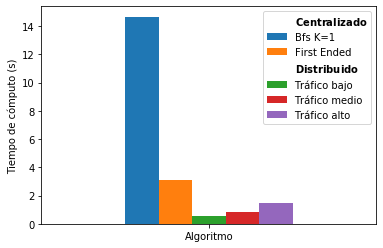

In [129]:
ax = plt.subplot(111)
plot_time_to_compute_routes(df, spatial_modules=spatial_modules[0], slowing_factor=slowing_factor, ax=ax)
ax.set_xticklabels(['Algoritmo'], rotation=0)
ax.set_ylabel('Tiempo de cómputo (s)')

### Route size estimation

In [130]:
# Still missing CLA overhead
route_length_mean = get_route_length_mean(df)
computed_routes = get_computed_routes(df)
filtered_computed_routes = get_dest_only_computed_routes(df)
recv = get_packets_received(df, '123')
sent = get_packets_sent(df)
delay = get_mean_delay(df)
size = get_route_size_estimation(df)
filtered_size = get_route_size_estimation(df, get_routes_func=get_dest_only_computed_routes)
#cr_filtered = get_dest_only_computed_routes(df)
#size_filtered = get_route_size_estimation(df, get_routes_func=get_dest_only_computed_routes)
merged_df = merge_dfs([config, sent, route_length_mean, computed_routes, size, filtered_computed_routes, filtered_size], how='outer')
merged_df = merged_df.round(2)

merged_df['Config'] = merged_df['Config'].apply(translate_config)
merged_df = merged_df.rename(columns={
    'Config': 'Algoritmo',
    'RouteLengthMean': 'Longitud\nde ruta\npromedio',
    'ComputedRoutes': 'Rutas\ncomputadas',
    'RouteSizeEstimation(MB)': 'Espacio\nestimado (MB)',
    'PacketsSent': 'Paquete\nenviados',
})
merged_df = merged_df.reindex([0, 1, 2, 4, 3])
merged_df
#ax = render_mpl_table(merged_df, col_width=1.6, font_size=10, row_height=0.7)

Algoritmo  Paquete\nenviados  Longitud\nde ruta\npromedio  \
0            Bfs               2928                         3.85   
1   Tráfico alto               2928                         3.27   
2  Tráfico medio               1464                         3.32   
4    First Ended               2928                         4.62   
3   Tráfico bajo                976                         3.31   

   ComputedRoutes_x  RouteSizeEstimation(MB)_x  ComputedRoutes_y  \
0            622559                      11.51            6846.0   
1              1939                       0.03               0.0   
2              1223                       0.02               0.0   
4            840958                      18.04            7351.0   
3               891                       0.01               0.0   

   RouteSizeEstimation(MB)_y  
0                       0.13  
1                       0.00  
2                       0.00  
4                       0.16  
3                       0.00

### Power consumption estimation

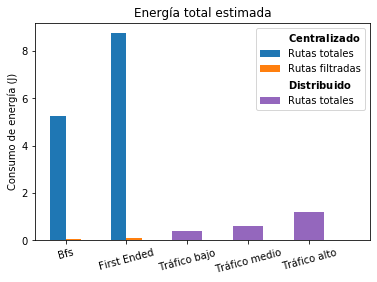

In [131]:
distributed_pc = get_power_consumption_distributed(
    df,
    spatial_modules[0],
    slowing_factor=slowing_factor,
    processor_power_consumption=processor_power_consumption
)
distributed_pc = merge_dfs([config, distributed_pc])
distributed_pc.set_index('Config', inplace=True)
distributed_pc = distributed_pc.loc[['TrafficLow', 'TrafficMedium', 'TrafficHigh'], :].reset_index()

centralized_pc = get_power_consumption_centralized(
    df,
    get_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)
centralized_pc_filtered = get_power_consumption_centralized(
    df,
    get_dest_only_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)

centralized_pc = pd.DataFrame({
    'run': centralized_pc['run'],
    'Rutas totales': centralized_pc['PowerConsumption(J)'],
    'Rutas filtradas': centralized_pc_filtered['PowerConsumption(J)']
})
centralized_pc = merge_dfs([config, centralized_pc]).set_index('Config')
ax = centralized_pc.plot(kind='bar')
xlabels = list(map(lambda x: x.get_text(), ax.get_xticklabels())) + distributed_pc['Config'].tolist()
xlabels = map(translate_config, xlabels)
ax.set_title('Energía total estimada')
ax.set_xticks(range(5))
ax.set_xlim(right=5)
ax.set_xticklabels(xlabels, rotation=15)
ax.set_xlabel('')
ax.set_ylabel('Consumo de energía (J)')
dist_bars = ax.bar([2, 3, 4], distributed_pc['PowerConsumption(J)'], width=0.5, color=['C4'])
h, l = ax.get_legend_handles_labels()
d1, = ax.plot([0], marker='None', linestyle='None')
d2, = ax.plot([0], marker='None', linestyle='None')
ax.legend([d1, *h, d2, dist_bars[0]], [r'$\bf{Centralizado}$', *l, r'$\bf{Distribuido}$', 'Rutas totales'])

### Energy boxplot

In [132]:
modules = spatial_modules[0]
# Distribuido
time_df = get_time_df(df,
    filter_modules=modules,
    spatial_modules=modules,
    slowing_factor=slowing_factor,
    agg_func=None)
config = get_config(df)
dfs = merge_dfs([config, time_df], drop_run=False)
dfs = dfs[[x in traffic_names for x in dfs['Config']]]
dfs['PowerConsumption(J)'] = dfs['SpentTime'] * processor_power_consumption
power_consumption_distributed = dfs[['run', 'module', 'Config', 'PowerConsumption(J)']]

# Centralizado
transmitted_routes = df[
    (df['type'] == 'scalar') & 
    (df['name'] == 'MCCTransmittedRoutes:sum')
][['run', 'value', 'module']].rename(columns={'value': 'TransmittedRoutes'})
transmitted_routes = filter_df_by_modules(transmitted_routes, modules=modules)
transmitted_routes


run  TransmittedRoutes  \
9157             Bfs-0-20210211-20:00:04-6519              760.0   
9238             Bfs-0-20210211-20:00:04-6519             1547.0   
9319             Bfs-0-20210211-20:00:04-6519              174.0   
9400             Bfs-0-20210211-20:00:04-6519              255.0   
9481             Bfs-0-20210211-20:00:04-6519              680.0   
9562             Bfs-0-20210211-20:00:04-6519              378.0   
9643             Bfs-0-20210211-20:00:04-6519              519.0   
9724             Bfs-0-20210211-20:00:04-6519              248.0   
9805             Bfs-0-20210211-20:00:04-6519             1048.0   
9886             Bfs-0-20210211-20:00:04-6519               44.0   
9967             Bfs-0-20210211-20:00:04-6519             1578.0   
10048            Bfs-0-20210211-20:00:04-6519              121.0   
19201     FirstEnded-0-20210211-19:59:46-6514              875.0   
19282     FirstEnded-0-20210211-19:59:46-6514             1835.0   
19363     FirstEnded-0-20210211-19:59:46-6514              174.0   
19444     FirstEnded-0-20210211-19:59:46-6514              255.0   
19525     FirstEnded-0-20210211-19:59:46-6514              852.0   
19606     FirstEnded-0-20210211-19:59:46-6514              406.0   
19687     FirstEnded-0-20210211-19:59:46-6514              675.0   
19768     FirstEnded-0-20210211-19:59:46-6514              266.0   
19849     FirstEnded-0-20210211-19:59:46-6514             1380.0   
19930     FirstEnded-0-20210211-19:59:46-6514               44.0   
20011     FirstEnded-0-20210211-19:59:46-6514             2149.0   
20092     FirstEnded-0-20210211-19:59:46-6514              129.0   
29245    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29326    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29407    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29488    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29569    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29650    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29731    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29812    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29893    TrafficHigh-0-20210211-20:00:01-6518                0.0   
29974    TrafficHigh-0-20210211-20:00:01-6518                0.0   
30055    TrafficHigh-0-20210211-20:00:01-6518                0.0   
30136    TrafficHigh-0-20210211-20:00:01-6518                0.0   
39289     TrafficLow-0-20210211-19:59:57-6516                0.0   
39370     TrafficLow-0-20210211-19:59:57-6516                0.0   
39451     TrafficLow-0-20210211-19:59:57-6516                0.0   
39532     TrafficLow-0-20210211-19:59:57-6516                0.0   
39613     TrafficLow-0-20210211-19:59:57-6516                0.0   
39694     TrafficLow-0-20210211-19:59:57-6516                0.0   
39775     TrafficLow-0-20210211-19:59:57-6516                0.0   
39856     TrafficLow-0-20210211-19:59:57-6516                0.0   
39937     TrafficLow-0-20210211-19:59:57-6516                0.0   
40018     TrafficLow-0-20210211-19:59:57-6516                0.0   
40099     TrafficLow-0-20210211-19:59:57-6516                0.0   
40180     TrafficLow-0-20210211-19:59:57-6516                0.0   
49333  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49414  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49495  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49576  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49657  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49738  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49819  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49900  TrafficMedium-0-20210211-19:59:59-6517                0.0   
49981  TrafficMedium-0-20210211-19:59:59-6517                0.0   
50062  TrafficMedium-0-20210211-19:59:59-6517                0.0   
50143  TrafficMedium-0-2021021

Text(0, 0.5, 'Energy estimation (J)')

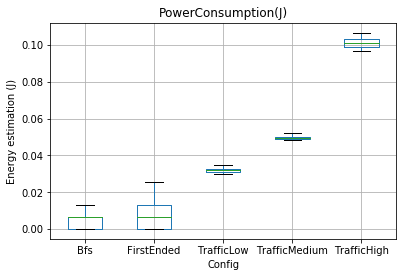

In [134]:
modules = spatial_modules[0]
# Distribuido
time_df = get_time_df(df,
    filter_modules=modules,
    spatial_modules=modules,
    slowing_factor=slowing_factor,
    agg_func=None)
config = get_config(df)
dfs = merge_dfs([config, time_df], drop_run=False)
dfs = dfs[[x in traffic_names for x in dfs['Config']]]
dfs['PowerConsumption(J)'] = dfs['SpentTime'] * processor_power_consumption
power_consumption_distributed = dfs[['run', 'module', 'Config', 'PowerConsumption(J)']]

# Centralizado
transmitted_routes = df[
    (df['type'] == 'scalar') & 
    (df['name'] == 'MCCTransmittedRoutes:sum')
][['run', 'value', 'module']].rename(columns={'value': 'TransmittedRoutes'})
transmitted_routes = filter_df_by_modules(transmitted_routes, modules=modules)

route_length = get_route_length_mean(df, modules=modules, group_by_run=False).drop(columns='name')

dfs = merge_dfs([route_length, transmitted_routes], drop_run=False, on=['run', 'module'])
dfs = merge_dfs([dfs, config], drop_run=False)
dfs = dfs[[x in centralized_names for x in dfs['Config']]]

size_estimation = dfs['RouteLengthMean'] * dfs['TransmittedRoutes'] * 4
size_estimation = size_estimation * 1.03 # add 3% corresponding to the convergence layer overhead
size_estimation /= 1024 ** 2 # MB
size_estimation = size_estimation.round(2)

dfs['PowerConsumption(J)'] = transmitter_power * \
        size_estimation / (transmitter_Mbps / 8)
power_consumption_centralized = dfs[['run', 'module', 'Config', 'PowerConsumption(J)']]
power_consumption = pd.concat([power_consumption_distributed, power_consumption_centralized])
power_consumption['Config'] = power_consumption['Config'].astype(config_order)
power_consumption.sort_values('Config', inplace=True)

ax = power_consumption.boxplot(column=['PowerConsumption(J)'], by='Config')
ax.get_figure().suptitle('')
ax.set_ylabel('Energy estimation (J)')

# Sim walker

In [7]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/sim_walker.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights'])
config = get_config(df)
k_param = get_iteration_vars(df, name='K')

### Route size estimation

In [14]:
route_length_mean = get_route_length_mean(df)
computed_routes = get_computed_routes(df)
recv = get_packets_received(df, '123')
delay = get_mean_delay(df)
merged_df = merge_dfs([config, k_param, recv, delay, route_length_mean, computed_routes], how='outer')
merged_df['RouteSizeEstimation (MB)'] = merged_df['ComputedRoutes'] * \
    get_route_size_estimation(merged_df['RouteLengthMean']) / (1024 ** 2)
merged_df.fillna(0).groupby(['Config', 'K']).mean().round(2).sort_values(['Config', 'K'])

PacketsReceived  Mean Delay  RouteLengthMean  ComputedRoutes  \
Config        K                                                                 
Bfs           1           8585.1     1110.38             6.13       1458190.2   
              2           8584.7     1109.00             6.89       2877986.6   
FirstEnded    0           8585.0     1110.36             7.52       1926220.0   
TrafficHigh   0           8585.4     1107.72             3.13          5092.3   
TrafficLow    0           2798.2     1131.69             3.08          2426.3   
TrafficMedium 0           4251.3     1115.81             3.09          3353.6   

                 RouteSizeEstimation (MB)  
Config        K                            
Bfs           1                     39.68  
              2                     86.64  
FirstEnded    0                     62.66  
TrafficHigh   0                      0.08  
TrafficLow    0                      0.04  
TrafficMedium 0                      0.05

# Random gen S1

In [3]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/random-gen.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights'])
config = get_config(df)
C_parameter = df[df['attrname'] == 'C'][['run', 'attrvalue']]
C_parameter = C_parameter.rename(columns={'attrvalue': 'Contacts'})
N_parameter = df[df['attrname'] == 'N'][['run', 'attrvalue']]
N_parameter = N_parameter.rename(columns={'attrvalue': 'N'})
df_conf = merge_dfs([df, N_parameter], drop_run=False)
spatial_modules = {
    34: {
        1: list(range(4, 14)),
        2: list(range(14, 24)),
        3: list(range(24, 34))
    },
    49: {
        1: list(range(4, 19)),
        2: list(range(19, 34)),
        3: list(range(34, 49))
    },
    64: {
        1: list(range(4, 24)),
        2: list(range(24, 44)),
        3: list(range(44, 64))
    }
}

def group_and_mean(df):
    df = merge_dfs([df, config, C_parameter])
    df = df.groupby(['Config', 'Contacts']).mean().unstack(0)
    df.columns = df.columns.droplevel()
    df.index = pd.to_numeric(df.index)
    return df.sort_index()

### Time to compute routes

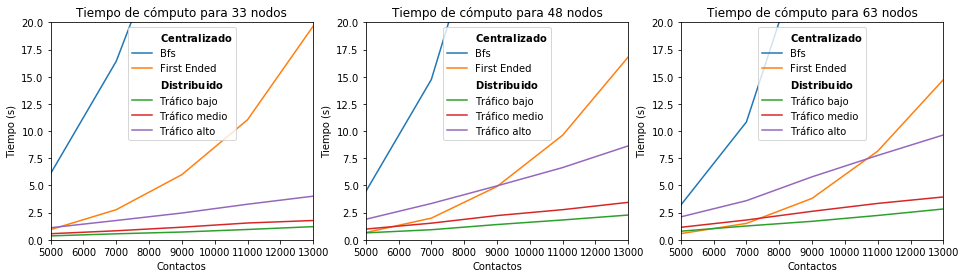

In [34]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for i in range(1, 4):
    nodes = 19 + 15 * i
    time_to_compute_routes = get_time_df(df_conf[df_conf['N'] == str(nodes)], spatial_modules=sum(spatial_modules[nodes].values(), []), slowing_factor=slowing_factor)
    time_to_compute_routes = merge_dfs([time_to_compute_routes, C_parameter, config])
    time_to_compute_routes = time_to_compute_routes.groupby(['Contacts', 'Config']).mean().unstack(1)

    time_to_compute_routes.index = pd.to_numeric(time_to_compute_routes.index)
    time_to_compute_routes.sort_index(inplace=True)
    time_to_compute_routes.columns = time_to_compute_routes.columns.droplevel()
    time_to_compute_routes = time_to_compute_routes[configs]
    
    ax = time_to_compute_routes.plot(kind='line', ax=axes[i-1])
    
    lines, labels = ax.get_legend_handles_labels()
    labels = list(map(translate_config, labels))
    d1, = ax.plot([0], marker='None', linestyle='None')
    d2, = ax.plot([0], marker='None', linestyle='None')
    ax.legend(
        (d1, *lines[:2], d2, *lines[2:]),
        (r'$\bf{Centralizado}$', *labels[:2], r'$\bf{Distribuido}$', *labels[2:]),
        loc='upper center')
    ax.set_xlabel('Contactos')
    ax.set_ylabel('Tiempo (s)')
    ax.set_ylim(0, 20)
    ax.set_title('Tiempo de cómputo para {} nodos'.format(18 + i*15))


### Number of computed routes

In [88]:
computed_routes = get_computed_routes(df)
merged_df = merge_dfs([computed_routes, config, N_parameter, C_parameter])
merged_df = merged_df.groupby(['Config', 'N', 'Contacts']).mean().unstack(0)
merged_df.columns = merged_df.columns.droplevel()
#merged_df.index = pd.to_numeric(merged_df.index)
merged_df

Config            Bfs  FirstEnded  TrafficHigh  TrafficLow  TrafficMedium
N  Contacts                                                              
34 11000          NaN    701255.5        722.2       243.0          362.9
   13000          NaN    961542.9        722.5       243.0          363.0
   5000      136257.4    171527.9        705.5       243.0          362.5
   7000      227720.4    316826.7        716.6       243.0          362.8
   9000      329197.0    497112.6        720.5       243.0          363.0
49 11000          NaN    848853.3       1120.8       376.0          564.0
   13000          NaN   1185679.5       1126.0       376.0          564.0
   5000      160570.4    184913.1       1026.6       375.4          557.5
   7000      273000.8    343086.6       1094.5       376.0          563.3
   9000      414589.1    576096.4       1112.0       376.0          563.9
64 11000          NaN    928832.3       1426.6       483.0          722.7
   13000          NaN   1296951.7       1433.7       483.0          722.9
   5000      181431.1    203647.5       1256.2       481.8          711.9
   7000      302864.9    355347.2       1364.1       482.8          720.7
   9000      462738.5    589188.7       1408.0       483.0          722.2

### Power consumption estimation

In [7]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))
for i in range(1, 4):
    nodes = 19 + 15 * i
    distributed_pc = get_power_consumption_distributed(
        df_conf[df_conf['N'] == str(nodes)],
        sum(spatial_modules[nodes].values(), []),
        slowing_factor=slowing_factor,
        processor_power_consumption=processor_power_consumption
    )
    
    distributed_pc = group_and_mean(distributed_pc)
    distributed_pc = distributed_pc.loc[:, ['TrafficLow', 'TrafficMedium', 'TrafficHigh']]
    
    centralized_pc = get_power_consumption_centralized(
        df_conf[df_conf['N'] == str(nodes)],
        get_computed_routes,
        transmitter_power=transmitter_power,
        transmitter_Mbps=transmitter_Mbps,
        modules_per_level=spatial_modules[nodes]
    )
    centralized_pc_filtered = get_power_consumption_centralized(
        df_conf[df_conf['N'] == str(nodes)],
        get_dest_only_computed_routes,
        transmitter_power=transmitter_power,
        transmitter_Mbps=transmitter_Mbps,
        modules_per_level=spatial_modules[nodes]
    )
    
    centralized_pc = group_and_mean(centralized_pc)
    centralized_pc_filtered = group_and_mean(centralized_pc_filtered)

    #power_consumption = pd.concat([centralized_pc_filtered, distributed_pc], axis=1)
    power_consumption = pd.concat([centralized_pc, distributed_pc], axis=1)
    ax = power_consumption.plot(kind='line', ax=axes[i - 1])
    ax.set_title('Energía estimada para {} nodos'.format(nodes - 1))
    ax.set_xlabel('Contactos')
    ax.set_ylabel('Consumo de energía (J)')
    ax.set_ylim(top=50)
    lines, labels = ax.get_legend_handles_labels()
    labels = list(map(translate_config, labels))
    d1, = ax.plot([0], marker='None', linestyle='None')
    d2, = ax.plot([0], marker='None', linestyle='None')
    ax.legend(
        (d1, *lines[:2], d2, *lines[2:]),
        (r'$\bf{Centralizado}$', *labels[:2], r'$\bf{Distribuido}$', *labels[2:]))
    

# Random gen S2

In [16]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/random-gen-s2.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights'])
config = get_config(df)
D_parameter = df[df['attrname'] == 'days'][['run', 'attrvalue']]
D_parameter = D_parameter.rename(columns={'attrvalue': 'Days'})
df_conf = merge_dfs([df, D_parameter], drop_run=False)

spatial_modules = {
    1: list(range(4, 14)),
    2: list(range(14, 24)),
    3: list(range(24, 34))
}

def group_and_mean(df):
    df = merge_dfs([df, config, D_parameter], drop_run=False)
    df = df.groupby(['Config', 'Days']).mean().unstack(0)
    df.columns = df.columns.droplevel()
    df.index = pd.to_numeric(df.index)
    return df.sort_index()

### Time to compute routes

Text(0.5, 1.0, 'Tiempo de cómputo')

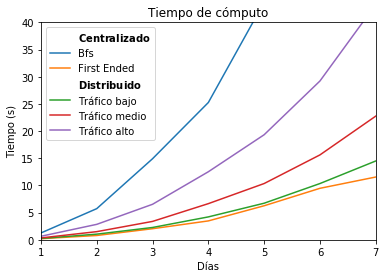

In [18]:
time_to_compute_routes = get_time_df(df_conf, spatial_modules=sum(spatial_modules.values(), []), slowing_factor=slowing_factor)

time_to_compute_routes = group_and_mean(time_to_compute_routes)
time_to_compute_routes = time_to_compute_routes[configs]

ax = time_to_compute_routes.plot(kind='line')

lines, labels = ax.get_legend_handles_labels()
labels = list(map(translate_config, labels))
d1, = ax.plot([0], marker='None', linestyle='None')
d2, = ax.plot([0], marker='None', linestyle='None')
ax.legend(
    (d1, *lines[:2], d2, *lines[2:]),
    (r'$\bf{Centralizado}$', *labels[:2], r'$\bf{Distribuido}$', *labels[2:])
)
ax.set_xlabel('Días')
ax.set_ylabel('Tiempo (s)')
ax.set_ylim(0, 40)
ax.set_title('Tiempo de cómputo')


### Rutas computadas

In [40]:
#cr = get_computed_routes(df)
cr = get_dest_only_computed_routes(df)
group_and_mean(cr)

Config      Bfs  FirstEnded  TrafficHigh  TrafficLow  TrafficMedium
Days                                                               
1        1998.3      2113.8          0.0         0.0            0.0
2        4100.4      4421.2          0.0         0.0            0.0
3        6458.2      7264.4          0.0         0.0            0.0
4        8557.0      9591.8          0.0         0.0            0.0
5       10968.1     12538.7          0.0         0.0            0.0
6       13279.0     15467.5          0.0         0.0            0.0
7       15011.7     17149.5          0.0         0.0            0.0

### Power consumption estimation

In [35]:
distributed_pc = get_power_consumption_distributed(
    df,
    sum(spatial_modules.values(), []),
    slowing_factor=slowing_factor,
    processor_power_consumption=processor_power_consumption
)

distributed_pc = group_and_mean(distributed_pc)
distributed_pc = distributed_pc.loc[:, ['TrafficLow', 'TrafficMedium', 'TrafficHigh']]

centralized_pc = get_power_consumption_centralized(
    df,
    get_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)
centralized_pc_filtered = get_power_consumption_centralized(
    df,
    get_dest_only_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)

centralized_pc = group_and_mean(centralized_pc)
centralized_pc_filtered = group_and_mean(centralized_pc_filtered)

power_consumption = pd.concat([centralized_pc_filtered, distributed_pc], axis=1)
#power_consumption = pd.concat([centralized_pc, distributed_pc], axis=1)
ax = power_consumption.plot(kind='line')
ax.set_title('Energía estimada')
ax.set_xlabel('Días')
ax.set_ylabel('Consumo de energía (J)')
ax.set_ylim(top=60)
lines, labels = ax.get_legend_handles_labels()
labels = list(map(translate_config, labels))
d1, = ax.plot([0], marker='None', linestyle='None')
d2, = ax.plot([0], marker='None', linestyle='None')
ax.legend(
    (d1, *lines[:2], d2, *lines[2:]),
    (r'$\bf{Centralizado}$', *labels[:2], r'$\bf{Distribuido}$', *labels[2:]))


# Lunar ringroad

In [161]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/lunar.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights', 'binvalues', 'binedges'])
config = get_config(df)
k_param = get_iteration_vars(df, name='K')
spatial_modules = {
    0: list(range(4, 8)),
    1: list(range(16, 24)),
    2: list(range(8, 16))
}

### Time to compute routes

In [162]:
ax = plt.subplot(111)
plot_time_to_compute_routes(df, spatial_modules=sum(spatial_modules.values(), []), slowing_factor=slowing_factor, ax=ax)
#plot_time_to_compute_routes(df, spatial_modules=sum(spatial_modules.values(), []), slowing_factor=1, ax=ax)
ax.set_xticklabels(['Algoritmo'], rotation=0)
ax.set_ylabel('Tiempo de cómputo (s)')

Text(0, 0.5, 'Tiempo de cómputo (s)')

### Route size estimation

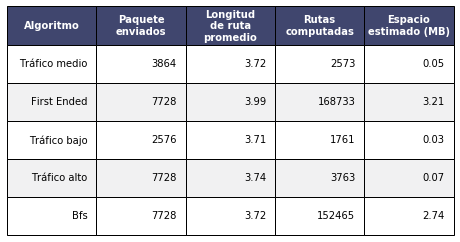

In [163]:
# Still missing CLA overhead
route_length_mean = get_route_length_mean(df)
computed_routes = get_computed_routes(df)
recv = get_packets_received(df, '123')
sent = get_packets_sent(df)
delay = get_mean_delay(df)
size = get_route_size_estimation(df)
merged_df = merge_dfs([config, sent, route_length_mean, computed_routes, size], how='outer')
merged_df = merged_df.round(2)

merged_df['Config'] = merged_df['Config'].apply(translate_config)
merged_df = merged_df.rename(columns={
    'Config': 'Algoritmo',
    'RouteLengthMean': 'Longitud\nde ruta\npromedio',
    'ComputedRoutes': 'Rutas\ncomputadas',
    'RouteSizeEstimation(MB)': 'Espacio\nestimado (MB)',
    'PacketsSent': 'Paquete\nenviados'
})
merged_df = merged_df.reindex([1, 3, 0, 4, 2])
ax = render_mpl_table(merged_df, col_width=1.6, font_size=10, row_height=0.7)

### Power consumption estimation

In [164]:
distributed_pc = get_power_consumption_distributed(
    df,
    sum(spatial_modules.values(), []),
    slowing_factor=slowing_factor,
    processor_power_consumption=processor_power_consumption
)
distributed_pc = merge_dfs([config, distributed_pc])
distributed_pc.set_index('Config', inplace=True)
distributed_pc = distributed_pc.loc[['TrafficLow', 'TrafficMedium', 'TrafficHigh'], :].reset_index()

centralized_pc = get_power_consumption_centralized(
    df,
    get_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)
centralized_pc_filtered = get_power_consumption_centralized(
    df,
    get_dest_only_computed_routes,
    transmitter_power=transmitter_power,
    transmitter_Mbps=transmitter_Mbps,
    modules_per_level=spatial_modules
)

centralized_pc = pd.DataFrame({
    'run': centralized_pc['run'],
    'Rutas totales': centralized_pc['PowerConsumption(J)'],
    'Rutas filtradas': centralized_pc_filtered['PowerConsumption(J)']
})
centralized_pc = merge_dfs([config, centralized_pc]).set_index('Config')
ax = centralized_pc.plot(kind='bar')
xlabels = list(map(lambda x: x.get_text(), ax.get_xticklabels())) + distributed_pc['Config'].tolist()
xlabels = map(translate_config, xlabels)
ax.set_title('Energía total estimada')
ax.set_xticks(range(5))
ax.set_xlim(right=5)
ax.set_xticklabels(xlabels, rotation=15)
ax.set_xlabel('')
ax.set_ylabel('Consumo de energía (J)')
dist_bars = ax.bar([2, 3, 4], distributed_pc['PowerConsumption(J)'], width=0.5, color=['C4'])
h, l = ax.get_legend_handles_labels()
d1, = ax.plot([0], marker='None', linestyle='None')
d2, = ax.plot([0], marker='None', linestyle='None')
ax.legend([d1, *h, d2, dist_bars[0]], [r'$\bf{Centralizado}$', *l, r'$\bf{Distribuido}$', 'Rutas totales'])

### Energy boxplot

In [166]:
modules = sum(spatial_modules.values(), [])
# Distribuido
time_df = get_time_df(df,
    filter_modules=modules,
    spatial_modules=modules,
    slowing_factor=slowing_factor,
    agg_func=None)
config = get_config(df)
dfs = merge_dfs([config, time_df], drop_run=False)
dfs = dfs[[x in traffic_names for x in dfs['Config']]]
dfs['PowerConsumption(J)'] = dfs['SpentTime'] * processor_power_consumption
power_consumption_distributed = dfs[['run', 'module', 'Config', 'PowerConsumption(J)']]

# Centralizado
transmitted_routes = df[
    (df['type'] == 'scalar') & 
    (df['name'] == 'MCCTransmittedRoutes:sum')
][['run', 'value', 'module']].rename(columns={'value': 'TransmittedRoutes'})
transmitted_routes = filter_df_by_modules(transmitted_routes, modules=modules)

route_length = get_route_length_mean(df, modules=modules, group_by_run=False).drop(columns='name')

dfs = merge_dfs([route_length, transmitted_routes], drop_run=False, on=['run', 'module'])
dfs = merge_dfs([dfs, config], drop_run=False)
dfs = dfs[[x in centralized_names for x in dfs['Config']]]

size_estimation = dfs['RouteLengthMean'] * dfs['TransmittedRoutes'] * 4
size_estimation = size_estimation * 1.03 # add 3% corresponding to the convergence layer overhead
size_estimation /= 1024 ** 2 # MB
size_estimation = size_estimation.round(2)

dfs['PowerConsumption(J)'] = transmitter_power * \
        size_estimation / (transmitter_Mbps / 8)
power_consumption_centralized = dfs[['run', 'module', 'Config', 'PowerConsumption(J)']]
power_consumption = pd.concat([power_consumption_distributed, power_consumption_centralized])
power_consumption['Config'] = power_consumption['Config'].astype(config_order)
power_consumption.sort_values('Config', inplace=True)

ax = power_consumption.boxplot(column=['PowerConsumption(J)'], by='Config')
ax.get_figure().suptitle('')
ax.set_ylabel('Energy estimation (J)')

Text(0, 0.5, 'Energy estimation (J)')

# Sim lunar

In [140]:
CSV_FILE = '../../simulations/centralized-vs-rev17/csvs/sim_lunar.csv'
df = pd.read_csv(CSV_FILE, low_memory=False)
df = df.drop(columns=['mean', 'count', 'stddev', 'min', 'max', 'sumweights'])
route_length_mean = get_route_length_mean(df)
computed_routes = get_computed_routes(df)
config = get_config(df)
k_param = get_iteration_vars(df, name='K')
recv = get_packets_received(df, '24')
delay = get_mean_delay(df)

FileNotFoundError: [Errno 2] File b'../../simulations/centralized-vs-rev17/csvs/sim_lunar.csv' does not exist: b'../../simulations/centralized-vs-rev17/csvs/sim_lunar.csv'

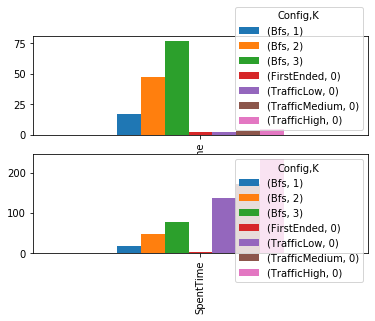

In [10]:
ax = plt.subplot(211)
plot_time_to_compute_routes(df, traffic_slowing_factor=1, ax=ax)
ax = plt.subplot(212)
plot_time_to_compute_routes(df, traffic_slowing_factor=slowing_factor, ax=ax)

In [12]:
merged_df = merge_dfs([config, k_param, recv, delay, route_length_mean, computed_routes], how='outer').fillna(0)
merged_df = merged_df.groupby(['Config', 'K']).mean().reset_index()
merged_df['RouteSizeEstimation (MB)'] = merged_df['ComputedRoutes'] * \
    get_route_size_estimation(merged_df['RouteLengthMean']) / (1024 ** 2)
merged_df.round(2)

Config  K  PacketsReceived  Mean Delay  RouteLengthMean  \
0            Bfs  1          22992.5     9055.89             4.17   
1            Bfs  2          22993.8     8889.97             4.73   
2            Bfs  3          22991.2     8890.56             5.09   
3     FirstEnded  0          22989.9     9057.88             4.64   
4    TrafficHigh  0          22965.5     8846.45             4.42   
5     TrafficLow  0           7693.1     8648.71             4.31   
6  TrafficMedium  0          11533.3     8704.22             4.35   

   ComputedRoutes  RouteSizeEstimation (MB)  
0        185769.9                      3.66  
1        329678.6                      7.21  
2        475850.3                     11.05  
3        227463.4                      4.89  
4          5555.9                      0.11  
5          3683.0                      0.07  
6          4379.3                      0.09